In [1]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import crop
from torchvision.io import read_image
import pandas as pd
from tqdm import tqdm
import os
import json
import cv2
import numpy as np

seed = 123
train_classes_frac = 0.7
num_epochs = 100
classes = { 0: "background",
            1: "short sleeve top", 
            2: "long sleeve top", 
            3: "short sleeve outwear",
            4: "long sleeve outwear",
            5: "vest",
            6: "sling",
            7 : "shorts",
            8 : "trousers",
            9 : "skirt", 
            10 : "short sleeve dress",
            11 : "long sleeve dress", 
            12 : "vest dress",
            13 : "sling dress"
            }

# Dataset preparation

First we convert a bunch of json's to a pandas dataframe

In [2]:
#from utils import convert_dataset
#convert_dataset(ann_dir=r"C:\Users\grk\git\StyleForge\data\validation\annos", output_path="deepfashion_val_segm.csv")
#convert_dataset(ann_dir="data/train/annos/", output_path="deepfashion_train.csv")

Now we create a dataset class

In [47]:
class DeepFashionDataset(Dataset):
    def __init__(self, df, transform=None, preprocessing=None):
        self.df = df[:100]
        self.transform = transform
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[[idx]]
        image = cv2.imread(row['crop_path'].values[0], cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(row['mask_path'].values[0], cv2.IMREAD_UNCHANGED)
        masks = [(mask == v) for v in classes]
        mask = np.stack(masks, axis=-1).astype('float')
        if self.transform:
            sample = self.transform(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask

# Augmentations

### check image sizes later

In [137]:
import albumentations as albu


def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(320, 320, border_mode=cv2.BORDER_CONSTANT, always_apply=True),
        albu.CenterCrop(320, 320, always_apply=True)
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

# Model, optimizer, losses

In [138]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['car']
ACTIVATION = None # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(classes), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [139]:
loss = smp.losses.DiceLoss(mode="multilabel")
loss.__name__ = 'dice_loss'
metrics = [
    smp.utils.metrics.IoU(),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# Training

In [140]:
from sklearn.model_selection import train_test_split

In [66]:
df = pd.read_csv("deepfashion_val_segm.csv")
df_train, df_val = train_test_split(df, test_size=0.2, random_state=seed, stratify=df["category_id"])

In [67]:
def collate_fn(data):
    images, masks = list(zip(*data))
    images = torch.tensor(images)
    masks = torch.tensor(masks).long()
    return images, masks

In [68]:
train_dataset = DeepFashionDataset(
    df_train,
    transform=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = DeepFashionDataset(
    df_val, 
    transform=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

c:\Users\grk\AppData\Local\Programs\Python\Python38\lib\site-packages\albumentations\augmentations\transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
c:\Users\grk\AppData\Local\Programs\Python\Python38\lib\site-packages\albumentations\augmentations\transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [11]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

In [145]:
#model = torch.load(r"C:\Users\grk\git\StyleForge\model_seg.ckpt")
model = torch.load(r"C:\Users\grk\git\StyleForge\model_seg.ckpt")

In [146]:
# helper function for data visualization
import matplotlib.pyplot as plt
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [147]:
preprocessing_fn = smp.encoders.get_preprocessing_fn("resnet34", "imagenet")
vis_dataset = DeepFashionDataset(df_val, transform=get_validation_augmentation())
test_dataset = DeepFashionDataset(df_val, transform=get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))

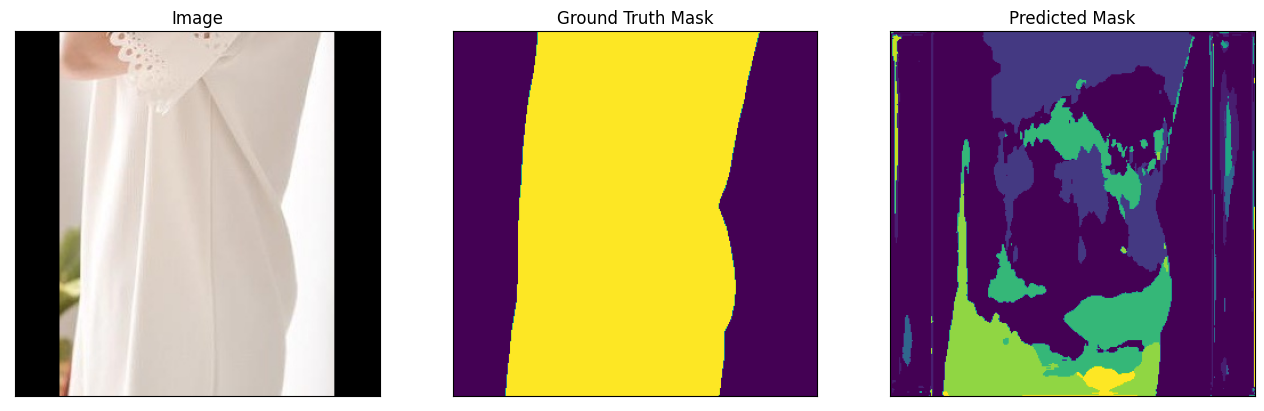

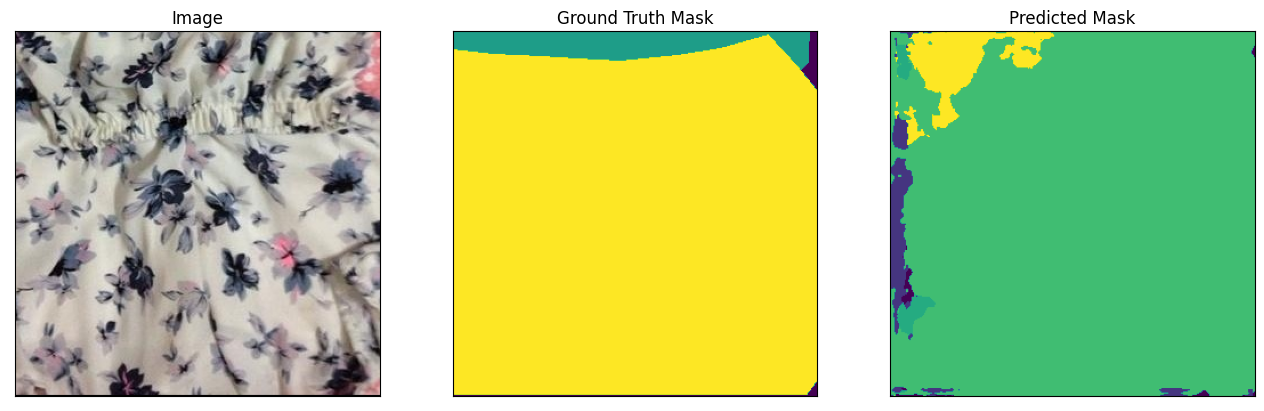

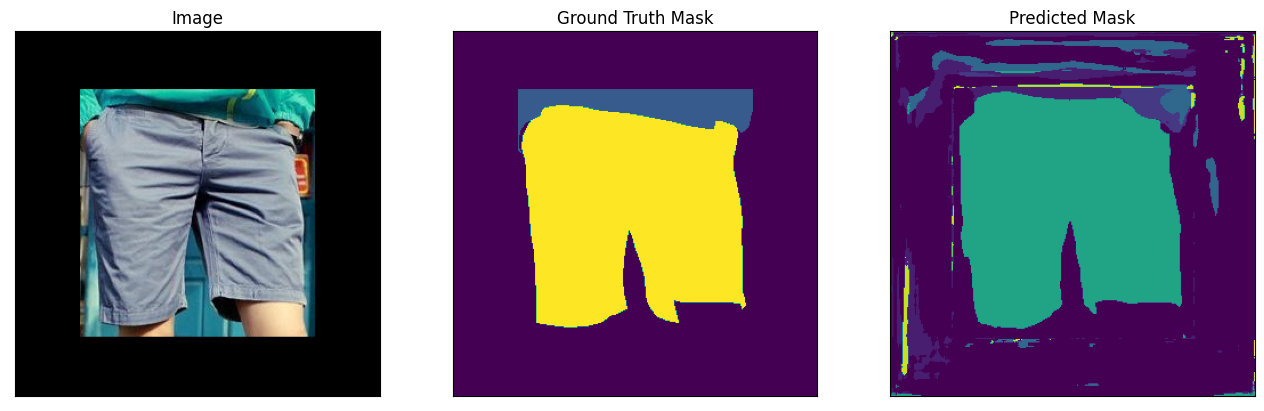

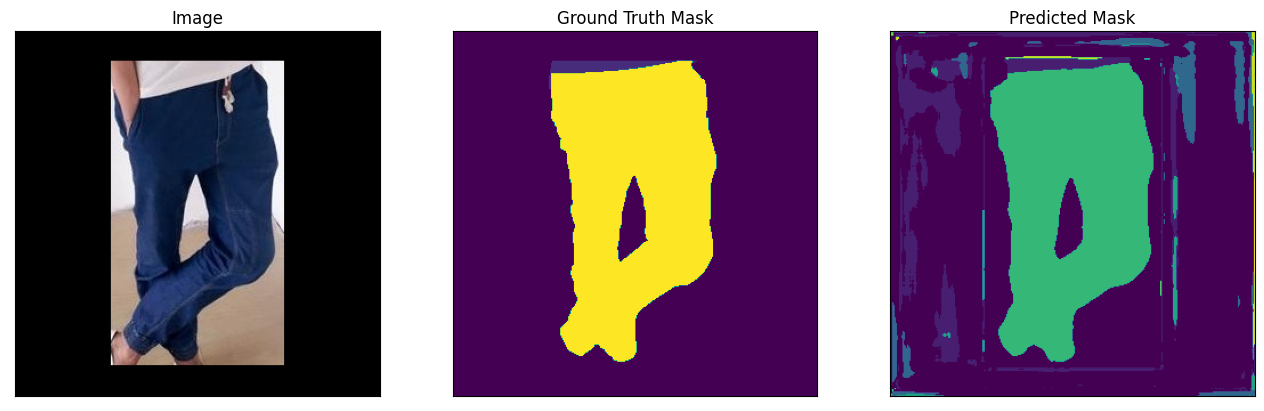

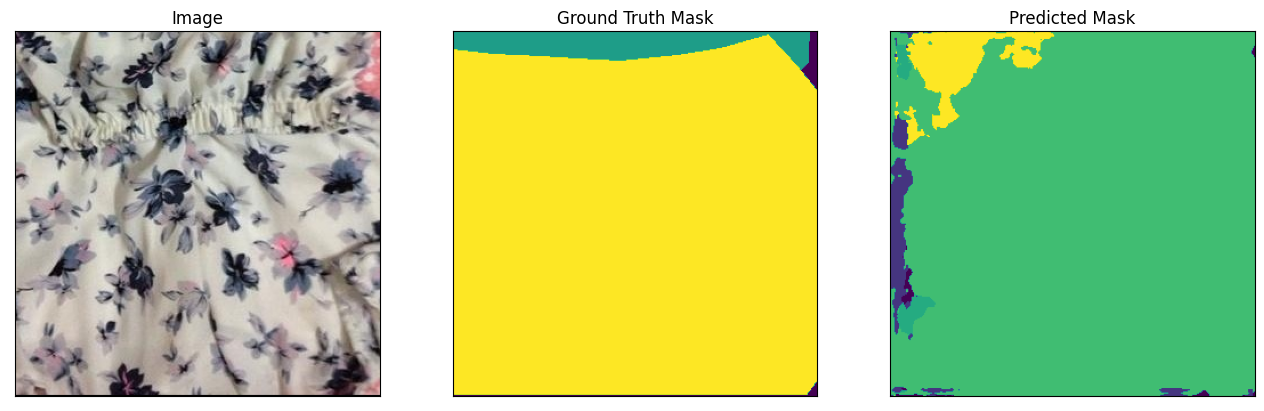

In [152]:
for i in range(5):
    n = np.random.choice(len(train_dataset))
    
    image_vis = cv2.cvtColor(vis_dataset[n][0].astype('uint8'), cv2.COLOR_BGR2RGB)
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    model.to(DEVICE)
    pr_mask = model.predict(x_tensor)
    
    pr_mask = (pr_mask.squeeze().cpu().numpy())
    pr_mask[pr_mask < 0.9] == 0
    visualize(
        image=image_vis, 
        #image=image.transpose(1,2,0),
        ground_truth_mask=np.argmax(gt_mask, axis=0), 
        predicted_mask=np.argmax(pr_mask, axis=0)
    )

In [113]:
image

array([[[ 2.0434113 ,  2.060536  ,  2.0091617 , ..., -0.14855725,
         -0.13143249, -0.08005822],
        [ 2.0434113 ,  2.060536  ,  2.0262866 , ..., -0.13143249,
         -0.08005822,  0.00556555],
        [ 2.0434113 ,  2.060536  ,  2.0091617 , ..., -0.06293347,
         -0.04580872,  0.12543882],
        ...,
        [ 1.1186745 ,  1.2042983 ,  1.0673003 , ..., -0.8335474 ,
         -0.81642264, -0.79929787],
        [ 1.2385478 ,  1.2727973 ,  1.1529241 , ..., -0.8335474 ,
         -0.8335474 , -0.81642264],
        [ 1.2556726 ,  1.2727973 ,  1.2042983 , ..., -0.8506721 ,
         -0.8506721 , -0.8506721 ]],

       [[ 2.4285715 ,  2.4285715 ,  2.4285715 , ..., -1.5105042 ,
         -1.5805322 , -1.5805322 ],
        [ 2.4285715 ,  2.4285715 ,  2.4285715 , ..., -1.5455182 ,
         -1.5455182 , -1.5105042 ],
        [ 2.4285715 ,  2.4285715 ,  2.4285715 , ..., -1.5630252 ,
         -1.5980393 , -1.4579831 ],
        ...,
        [ 0.99299717,  1.0455182 ,  0.99299717, ..., -

In [107]:
np.unique(gt_mask)

array([0., 1.], dtype=float32)

In [94]:
pr_mask.shape

(320, 320, 14)

In [14]:
pr_mask.shape

(14, 320, 320)

In [15]:
image_vis = train_dataset[n][0].astype('uint8')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


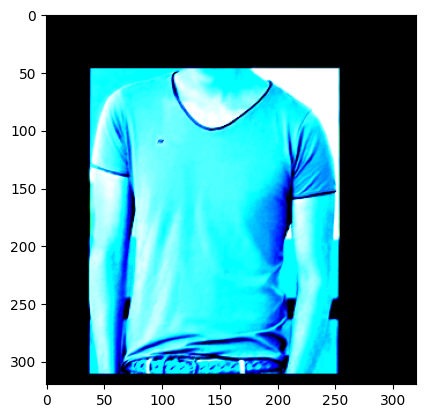

In [26]:
plt.imshow(image.transpose(1,2,0))

In [39]:
np.unique(pr_mask[3])

array([-2., -1., -0.,  1.,  2.,  3.,  4.,  5.], dtype=float32)

In [40]:
mask = np.argmax(pr_mask, axis=0)

In [42]:
mask.shape

(320, 320)

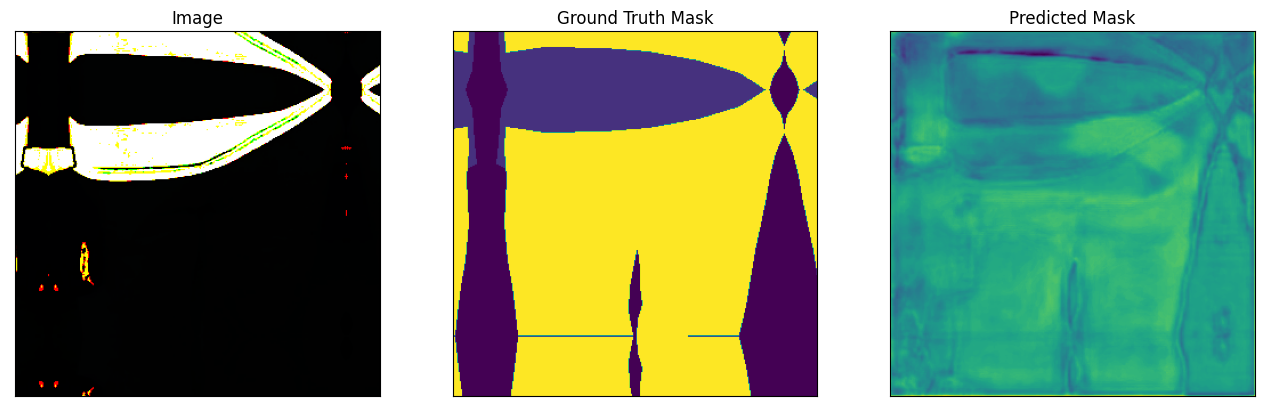

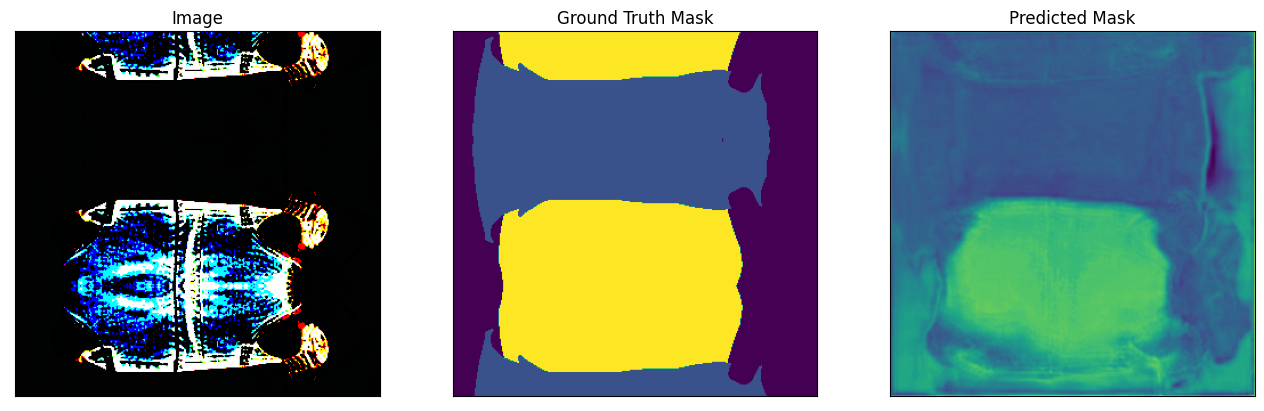

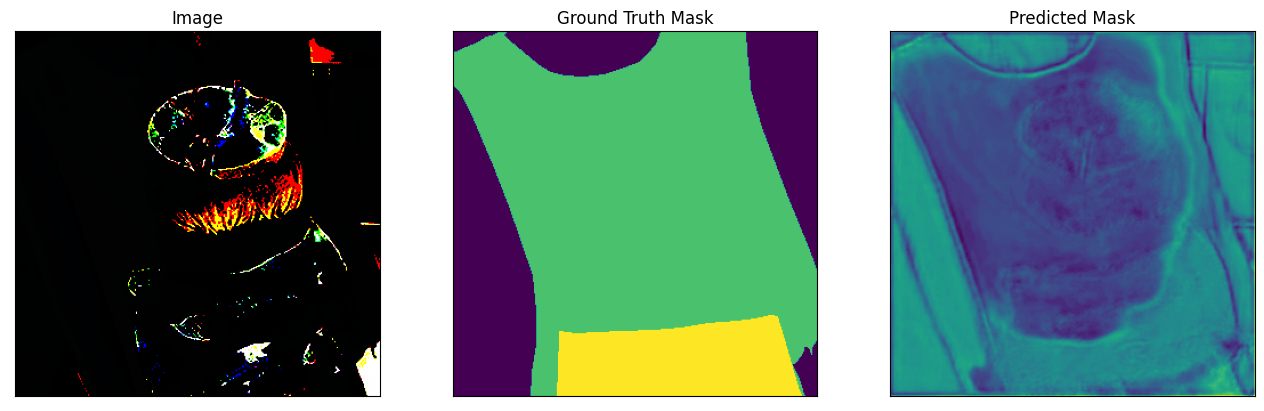

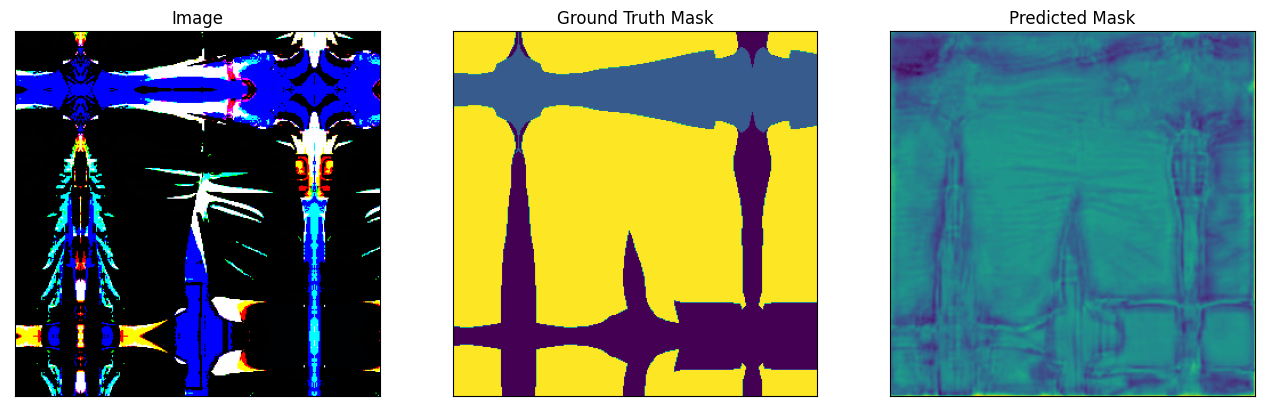

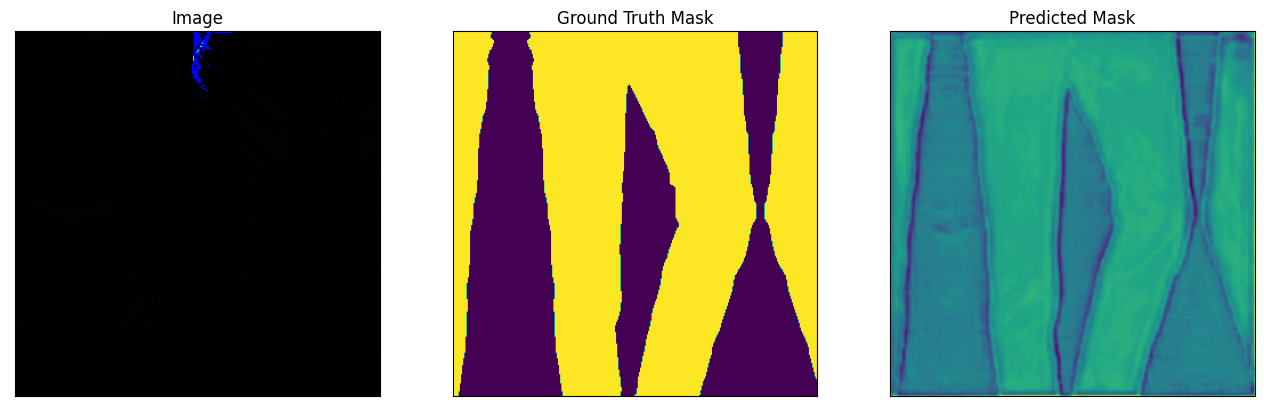

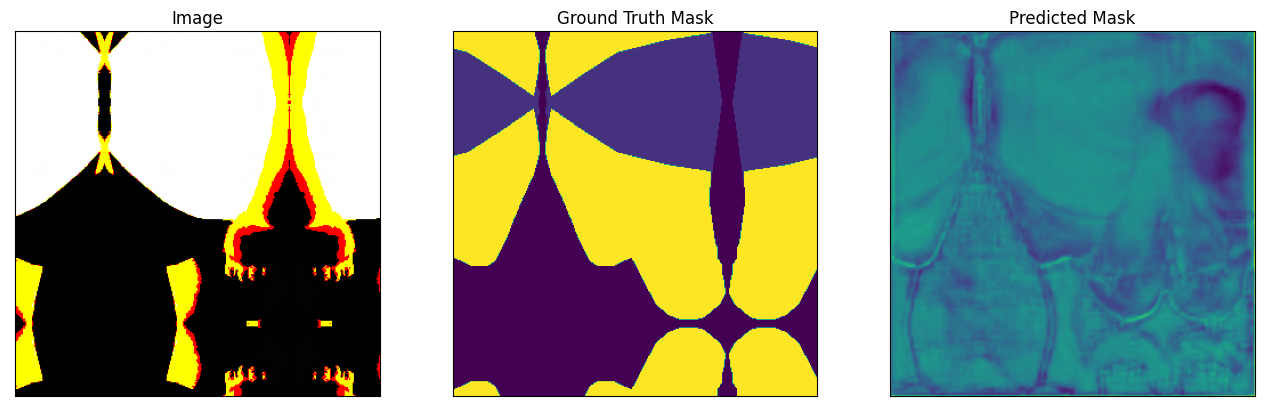

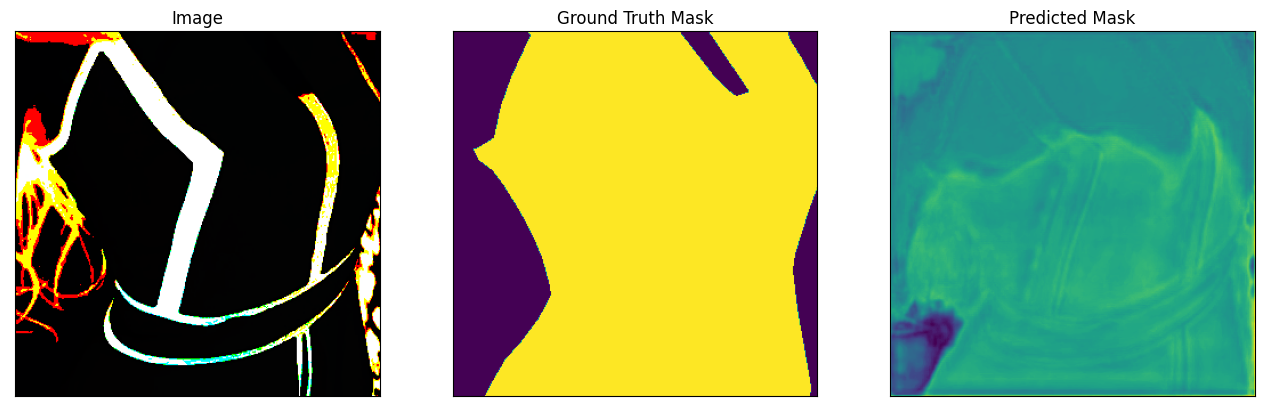

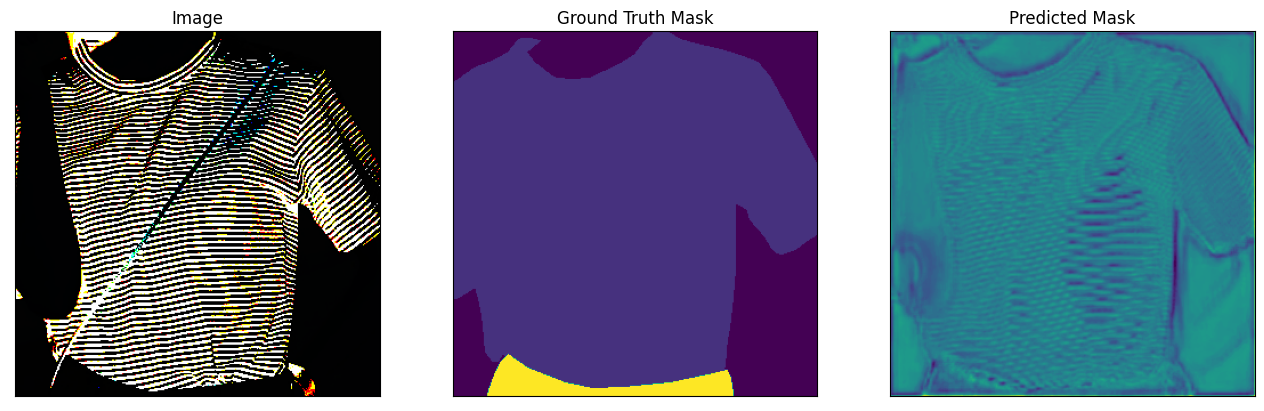

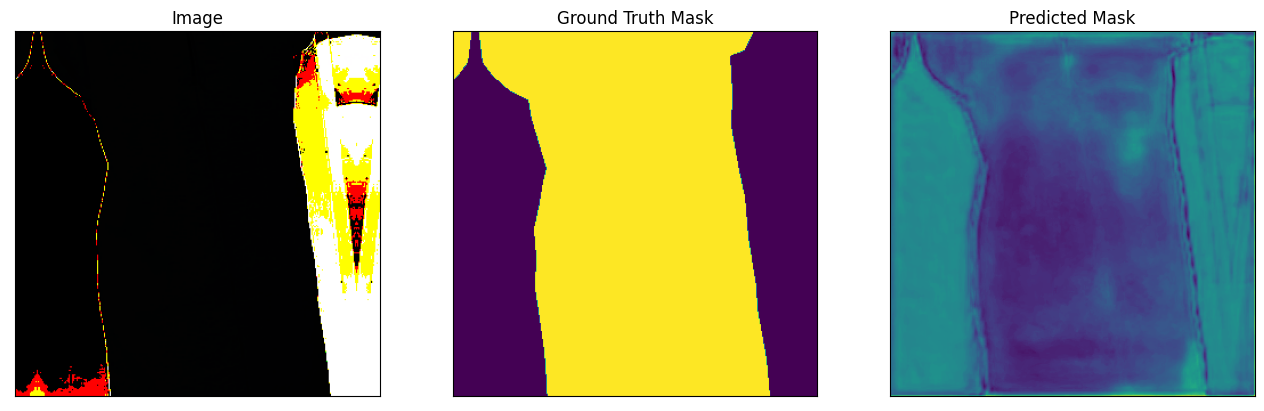

In [93]:
for i in range(9):
    n = np.random.choice(len(valid_dataset))
    
    image_vis = valid_dataset[n][0].astype('uint8')
    image, gt_mask = valid_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    gt_mask = np.transpose(gt_mask, (1, 2, 0))
    pr_mask = np.transpose(pr_mask, (1, 2, 0))

    
    gt_mask_gray = np.zeros((gt_mask.shape[0],gt_mask.shape[1]))

    for ii in range(gt_mask.shape[2]):
        gt_mask_gray = gt_mask_gray + 1/gt_mask.shape[2]*ii*gt_mask[:,:,ii]
    
    pr_mask_gray = np.zeros((pr_mask.shape[0],pr_mask.shape[1]))
    for ii in range(pr_mask.shape[2]):
        pr_mask_gray = pr_mask_gray + 1/pr_mask.shape[2]*ii*pr_mask[:,:,ii]
    
        
    visualize(
        image=image_vis.transpose(1,2,0), 
        ground_truth_mask=gt_mask_gray, 
        predicted_mask=pr_mask_gray
    )